In [31]:
import pandas as pd
import numpy as np
import talib
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
def tick_to_minute(df, freq="min"):
    """
    将Tick数据转换为分钟级OHLC数据
    :param tick_df: DataFrame, 需包含时间戳索引和price/volume列
    :param freq: 重采样频率（默认为1分钟）
    :return: 分钟级DataFrame
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['time'])
    df.set_index('datetime', inplace=True)

    # 2. 使用 resample 将 tick 数据转换为分钟级数据
    # 计算价格的 OHLC 以及成交量的总和
    df_minute = df.resample(freq).agg({
        'price': ['first', 'max', 'min', 'last'],
        'volume': 'sum'
    })

    # 3. 整理列名称（可选）
    df_minute.columns = ['open', 'high', 'low', 'close', 'volume']
    df_minute = df_minute.reset_index()
    
    # 处理空值
    df_minute = df_minute.dropna()  # 或填充：minute_df.ffill()
    
    return df_minute

In [ ]:
# dirpath = 'FutSF_TickKZ_CTP_Daily_202301'
# direc = os.listdir(dirpath)

# wholef = pd.DataFrame()
# for file_name in direc:
#     if 'IC' not in file_name:
#         continue
#     df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

#     f = df[['最新价','数量']].copy()
#     f.columns = ['price','volume']
#     f.loc[:,'time'] = pd.to_datetime(df['交易日'].astype(str) + ' ' + df['最后修改时间'])
#     ff = tick_to_minute(f, freq="min").iloc[:-4,:]
#     wholef=pd.concat([wholef,ff],ignore_index=True)

dirpath = 'data/IM'
direc = os.listdir(dirpath)

wholef = pd.DataFrame()
for file_name in direc:

    df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

    f = df[['LastPrice','Volume']].copy()
    f.columns = ['price','volume']
    f.loc[:,'time'] = pd.to_datetime(df['TradingDay'].astype(str) + ' ' + df['UpdateTime'])
    ff = tick_to_minute(f, freq="min").iloc[1:-2,:]
    wholef=pd.concat([wholef,ff],ignore_index=True)


In [ ]:
dirpath = 'data/IM'
direc = os.listdir(dirpath)
pre,cur = direc[0],direc[1]
pref,df = pd.read_csv(os.path.join(dirpath,pre), encoding='gbk'),pd.read_csv(os.path.join(dirpath,cur), encoding='gbk')

,ActionDay,AskPrice1,AskPrice2,AskPrice3,AskPrice4,AskPrice5,AskVolume1,AskVolume2,AskVolume3,AskVolume4,...,PreDelta,PreOpenInterest,PreSettlementPrice,SettlementPrice,TradingDay,Turnover,UpdateMillisec,UpdateTime,UpperLimitPrice,Volume
0,20230302,NaN,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,0.000000e+00,200,07:04:57,7026.4,0
1,20230302,6390.0,NaN,NaN,NaN,NaN,2,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,1.623009e+08,200,09:29:00,7026.4,127
2,20230302,6387.8,NaN,NaN,NaN,NaN,6,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,2.019016e+08,200,09:30:00,7026.4,158
3,20230302,6386.6,NaN,NaN,NaN,NaN,4,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,2.478816e+08,700,09:30:00,7026.4,194
4,20230302,6384.4,NaN,NaN,NaN,NaN,1,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,2.683130e+08,200,09:30:01,7026.4,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25411,20230302,6381.6,NaN,NaN,NaN,NaN,1,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,4.374272e+10,200,14:59:59,7026.4,34278
25412,20230302,6382.4,NaN,NaN,NaN,NaN,10,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,4.374910e+10,700,14:59:59,7026.4,34283
25413,20230302,6382.2,NaN,NaN,NaN,NaN,2,0,0,0,...,NaN,132447.0,6387.8,NaN,20230302,4.375165e+10,200,15:00:00,7026.4,34285
25414,20230302,6382.2,NaN,NaN,NaN,NaN,2,0,0,0,...,NaN,132447.0,6387.8,6374.8,20230302,4.375165e+10,200,15:28:02,7026.4,34285


In [ ]:
class Variable:

    def __init__(self,para,df):
        self.para = para
        self.df = df
        self.SRevert = -np.inf
        self.BRevert = np.inf
        self.div = 3
        self.ifSetup = None
    
    def CalFixedBands(self):
        r1,r2,r3 = self.para
        H,L,C = max(self.df['LastPrice']),min(self.df['LastPrice']),self.df['LastPrice'].iloc[-1]

        self.SEnter = ((1 + r1)/2 *(H + C)) - r1 * L
        self.BEnter = ((1 + r1) / 2 * (L + C)) - r1 * H
        self.SSetup = H + r2 * (C - L)
        self.BSetup = L - r2 * (H - C)
        self.BBreak = self.SSetup + r3 * (self.SSetup - self.BSetup)
        self.SBreak = self.BSetup - r3 * (self.SSetup - self.BSetup)
    
    def CalFloatingBand(self,tdhigh,tdlow):
        self.SRevert = self.SEnter + (tdhigh - self.SSetup) / self.div
        self.BRevert = self.BEnter + (tdlow - self.BSetup) / self.div


In [73]:
def rbreaker_backtest(df,pref,init_pos = 0, para = [0.01,0.01,0.01], atr_period=2, add_threshold=0.5, stop_loss_mult=2, cost = 0.6):
    
    if df['InstrumentID'][0] != pref['InstrumentID'][0]:
        return None,None
    
    df,pref = df.copy(),pref.copy()

    variable = Variable(para,pref)
    variable.CalFixedBands()
    
    f = df[['LastPrice','Volume']].copy()
    f.columns = ['price','volume']
    f.loc[:,'time'] = pd.to_datetime(df['TradingDay'].astype(str) + ' ' + df['UpdateTime'])
    df = tick_to_minute(f, freq="min").iloc[1:-2,:]

    # 计算 ATR（周期为 atr_period）
    df['ATR'] = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=atr_period)
    
    # 初始化各列
    df['Signal'] = 0           # 信号：1 表示开多或加多，-1 表示开空或加空，0 表示平仓
    df['Position'] = 0         # 持仓数量（正数为多头，负数为空头）
    df['Trade_Price'] = np.nan # 当天发生交易时记录价格
    df['Cum_PnL'] = 0.0        # 累计盈亏
    
    position = 0             # 当前持仓数量
    entry_prices = []        # 记录每个入场单的价格（用于加仓及止损）
    last_entry = None        # 最近一次入场价格
    cumulative_pnl = 0.0
    trade_log = []           # 用于记录每笔交易详情
    
    current_date = df.index[0]
    close = df.iloc[0]['close']
    if init_pos > 0:
        position = 1
        entry_prices = [close]
        last_entry = close
        df.at[current_date, 'Signal'] = 1
        df.at[current_date, 'Trade_Price'] = close
        trade_log.append({
            'Entry_Date': current_date,
            'Direction': 'Long',
            'Entry_Prices': entry_prices.copy()
        })
        
    if init_pos < 0:
        position = -1
        entry_prices = [close]
        last_entry = close
        df.at[current_date, 'Signal'] = -1
        df.at[current_date, 'Trade_Price'] = close
        trade_log.append({
            'Entry_Date': current_date,
            'Direction': 'Short',
            'Entry_Prices': entry_prices.copy()
        })

    # 从 channel_period 行开始遍历（前面数据不足无法计算通道）
    for i in range(len(df)):
        current_date = df.index[i]
        close,high,low = df.iloc[i]['close'],df.iloc[i]['high'],df.iloc[i]['low']
        atr = df.iloc[i]['ATR']
        
        if high > variable.BBreak and variable.BBreak > variable.SRevert:
            if position < 0:
                pnl = sum([price - close - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None

            if position == 0:
                position = 1
                entry_prices = [close]
                last_entry = close
                df.at[current_date, 'Signal'] = 1
                df.at[current_date, 'Trade_Price'] = close
                trade_log.append({
                    'Entry_Date': current_date,
                    'Direction': 'Long',
                    'Entry_Prices': entry_prices.copy()
                })

        if low < variable.SBreak and variable.SBreak < variable.BRevert:
            if position > 0:
                pnl = sum([close - price - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None

            if position == 0:
                position = -1
                entry_prices = [close]
                last_entry = close
                df.at[current_date, 'Signal'] = -1
                df.at[current_date, 'Trade_Price'] = close
                trade_log.append({
                    'Entry_Date': current_date,
                    'Direction': 'Short',
                    'Entry_Prices': entry_prices.copy()
                })

        if variable.ifSetup == 'BSetup':
            if high > variable.BRevert:
                if position < 0:
                    pnl = sum([price - close - cost for price in entry_prices])
                    cumulative_pnl += pnl
                    df.at[current_date, 'Signal'] = 0  # 平仓信号
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1].update({
                        'Exit_Date': current_date,
                        'Exit_Price': close,
                        'PnL': pnl
                    })
                    position = 0
                    entry_prices = []
                    last_entry = None

                if position == 0:
                    position = 1
                    entry_prices = [close]
                    last_entry = close
                    df.at[current_date, 'Signal'] = 1
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log.append({
                        'Entry_Date': current_date,
                        'Direction': 'Long',
                        'Entry_Prices': entry_prices.copy()
                    })
        if variable.ifSetup == 'SSetup':
            if low < variable.SRevert:
                if position > 0:
                    pnl = sum([close - price - cost for price in entry_prices])
                    cumulative_pnl += pnl
                    df.at[current_date, 'Signal'] = 0  # 平仓信号
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1].update({
                        'Exit_Date': current_date,
                        'Exit_Price': close,
                        'PnL': pnl
                    })
                    position = 0
                    entry_prices = []
                    last_entry = None

                    if position == 0:
                        position = -1
                        entry_prices = [close]
                        last_entry = close
                        df.at[current_date, 'Signal'] = -1
                        df.at[current_date, 'Trade_Price'] = close
                        trade_log.append({
                            'Entry_Date': current_date,
                            'Direction': 'Short',
                            'Entry_Prices': entry_prices.copy()
                        })
        if position > 0:
            if high >= last_entry + add_threshold * atr:
                position += 1
                entry_prices.append(close)
                last_entry = close  # 更新最新入场价格
                df.at[current_date, 'Signal'] = 1  # 表示加仓
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1]['Entry_Prices'] = entry_prices.copy()
            # 止损条件：当前价格低于最近入场价格减去 stop_loss_mult × ATR
            elif low <= last_entry - stop_loss_mult * atr:
                pnl = sum([close - price - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None
        
        if position < 0:
            if low <= last_entry - add_threshold * atr:
                position -= 1
                entry_prices.append(close)
                last_entry = close
                df.at[current_date, 'Signal'] = -1  # 表示加仓
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1]['Entry_Prices'] = entry_prices.copy()

            elif high >= last_entry + stop_loss_mult * atr:
                pnl = sum([price - close - cost for price in entry_prices])
                cumulative_pnl += pnl
                df.at[current_date, 'Signal'] = 0  # 平仓信号
                df.at[current_date, 'Trade_Price'] = close
                trade_log[-1].update({
                    'Exit_Date': current_date,
                    'Exit_Price': close,
                    'PnL': pnl
                })
                position = 0
                entry_prices = []
                last_entry = None

        variable.CalFloatingBand(df['high'].iloc[i],df['low'].iloc[i])
        if high > variable.SSetup:
            variable.ifSetup = 'SSetup'
        if low < variable.BSetup:
            variable.ifSetup = 'BSetup'

        # 记录当天的持仓和累计盈亏
        df.at[current_date, 'Position'] = position
        df.at[current_date, 'Cum_PnL'] = cumulative_pnl
    
    # 最后，在 for 循环结束后，若仍有未平仓仓位，则使用最后一根K线的价格平仓
    if position != 0:
        final_date = df.index[-1]
        final_price = df.iloc[-1]['close']
        if position > 0:
            pnl = sum([final_price - price - cost for price in entry_prices])
        else:
            pnl = sum([price - final_price - cost for price in entry_prices])
        cumulative_pnl += pnl
        # 更新最后一笔交易记录，标记为最终平仓
        if trade_log:
            trade_log[-1].update({
                'Exit_Date': final_date,
                'Exit_Price': final_price,
                'PnL': pnl
            })
        df.at[final_date, 'Signal'] = 0
        df.at[final_date, 'Trade_Price'] = final_price
        df.at[final_date, 'Position'] = 0
        df.at[final_date, 'Cum_PnL'] = cumulative_pnl
        position = 0
        entry_prices = []
        last_entry = None
    
    return df, trade_log

In [74]:
pred = -1
ap,at,sl = [2,0.5,2.4]
r1r2r3 = [0.55,0.6,0.9]
code = 'IM'
fpath = 'data/' + code
prename = f'{code}_{pd.to_datetime('20230314').strftime("%Y%m%d")}.csv'
name = f'{code}_{pd.to_datetime('2023-03-15').strftime("%Y%m%d")}.csv'

pref = pd.read_csv(os.path.join(fpath,prename), encoding='gbk')
df = pd.read_csv(os.path.join(fpath,name), encoding='gbk')
result, trades = rbreaker_backtest(df, pref, pred, r1r2r3, atr_period=ap, add_threshold=at, stop_loss_mult=sl)

# 输出最后几行回测结果
print(result.tail())

total_pnl = 0
# 输出交易记录
print("交易记录：")
for trade in trades:
    print(trade)
    total_pnl += trade.get('PnL', 0)
print(total_pnl)

               datetime    open    high     low   close   volume       ATR  \
472 2023-03-15 14:56:00  6806.0  6806.4  6804.6  6806.2  4041868  2.381875   
473 2023-03-15 14:57:00  6805.6  6806.4  6805.0  6805.4  4021961  1.890937   
474 2023-03-15 14:58:00  6805.4  6806.6  6804.8  6806.0  4005571  1.845469   
475 2023-03-15 14:59:00  6805.2  6807.4  6805.0  6807.2  4174420  2.122734   
476 2023-03-15 15:00:00  6807.2  6807.2  6807.2  6807.2    37688  1.061367   

     Signal  Position  Trade_Price  Cum_PnL  
472       0         0          NaN    -18.8  
473       0         0          NaN    -18.8  
474       0         0          NaN    -18.8  
475       0         0          NaN    -18.8  
476       0         0          NaN    -18.8  
交易记录：
{'Entry_Date': 145, 'Direction': 'Short', 'Entry_Prices': [6800.0], 'Exit_Date': 148, 'Exit_Price': 6818.2, 'PnL': -18.79999999999982}
-18.79999999999982


In [68]:
result

,datetime,open,high,low,close,volume,ATR,Signal,Position,Trade_Price,Cum_PnL
145,2023-03-15 09:29:00,6800.0,6800.0,6800.0,6800.0,62,NaN,-1,0,6800.0,0.0
146,2023-03-15 09:30:00,6803.0,6816.8,6803.0,6809.8,72888,NaN,-1,0,6809.8,0.0
147,2023-03-15 09:31:00,6809.8,6820.0,6809.8,6818.0,142503,13.500000,-1,0,6818.0,0.0
148,2023-03-15 09:32:00,6819.0,6824.6,6818.2,6818.2,199445,10.050000,-1,0,6818.2,0.0
149,2023-03-15 09:33:00,6819.0,6824.8,6816.8,6822.0,249515,9.025000,-1,0,6822.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
472,2023-03-15 14:56:00,6806.0,6806.4,6804.6,6806.2,4041868,2.381875,-1,0,6806.2,0.0
473,2023-03-15 14:57:00,6805.6,6806.4,6805.0,6805.4,4021961,1.890937,-1,0,6805.4,0.0
474,2023-03-15 14:58:00,6805.4,6806.6,6804.8,6806.0,4005571,1.845469,-1,0,6806.0,0.0
475,2023-03-15 14:59:00,6805.2,6807.4,6805.0,6807.2,4174420,2.122734,-1,0,6807.2,0.0


In [65]:
def func(ca,rtotal,total = [],code = 'IM'):

    ap,at,sl = ca
    cur_max = 0
    fpath = 'data/' + code
    direc = os.listdir(fpath)
    reftd = pd.read_csv(f'preds/{code}.csv')
    # startdate = min([int(i.split('.')[0].split('_')[1]) for i in direc])
    # enddate = max([int(i.split('.')[0].split('_')[1]) for i in direc])
    
    startdate,enddate = '2023-03-12','2023-03-17'

    reftd = reftd[(pd.to_datetime(reftd['Date']) >= pd.to_datetime(str(startdate))) & 
                  (pd.to_datetime(reftd['Date']) <= pd.to_datetime(str(enddate)))].reset_index(drop=True)

    result = []
    for i in tqdm(range(len(reftd) - 1)):
        prename = f'{code}_{pd.to_datetime(reftd["Date"][i]).strftime("%Y%m%d")}.csv'
        name = f'{code}_{pd.to_datetime(reftd["Date"][i+1]).strftime("%Y%m%d")}.csv'
        if prename not in direc or name not in direc:
            continue
        pref = pd.read_csv(os.path.join(fpath,prename), encoding='gbk')
        df = pd.read_csv(os.path.join(fpath,name), encoding='gbk')
        pred = reftd['pred'][i]

        def subfunc(r1r2r3):

            result, trades = rbreaker_backtest(df, pref, pred, r1r2r3, atr_period=ap, add_threshold=at, stop_loss_mult=sl)

            day_pnl = 0
            day_trades = 0
            if trades is not None:
                for trade in trades:
                    day_pnl += trade.get('PnL', 0)
                day_trades += len(trades)
            else:
                day_pnl = -1000000
                day_trades = -1
            
            print(trades)

            return [r1r2r3[0],r1r2r3[1],r1r2r3[2],ap,at,sl,day_pnl,day_trades]

        result.append(subfunc(rtotal))

    return result

# apatsl = list(itertools.product([x for x in range(2,20)],[x / 10 for x in range(1,20)], [x / 10 for x in range(2,20)]))
apatsl = [[2,0.5,2.4]]
n = 20

resultss = []
r = []
for c in apatsl:
    r = func(c,[0.55,0.6,0.9],r,code = 'IM')


 25%|██▌       | 1/4 [00:00<00:01,  2.00it/s]

[{'Entry_Date': 145, 'Direction': 'Short', 'Entry_Prices': [6820.6]}, {'Entry_Date': 146, 'Direction': 'Short', 'Entry_Prices': [6819.8]}, {'Entry_Date': 147, 'Direction': 'Short', 'Entry_Prices': [6827.4]}, {'Entry_Date': 148, 'Direction': 'Short', 'Entry_Prices': [6826.6]}, {'Entry_Date': 149, 'Direction': 'Short', 'Entry_Prices': [6823.0]}, {'Entry_Date': 150, 'Direction': 'Short', 'Entry_Prices': [6816.4]}, {'Entry_Date': 151, 'Direction': 'Short', 'Entry_Prices': [6809.6]}, {'Entry_Date': 152, 'Direction': 'Short', 'Entry_Prices': [6806.4]}, {'Entry_Date': 153, 'Direction': 'Short', 'Entry_Prices': [6811.0]}, {'Entry_Date': 154, 'Direction': 'Short', 'Entry_Prices': [6804.4]}, {'Entry_Date': 155, 'Direction': 'Short', 'Entry_Prices': [6811.8]}, {'Entry_Date': 156, 'Direction': 'Short', 'Entry_Prices': [6808.2]}, {'Entry_Date': 157, 'Direction': 'Short', 'Entry_Prices': [6802.2]}, {'Entry_Date': 158, 'Direction': 'Short', 'Entry_Prices': [6794.6]}, {'Entry_Date': 159, 'Direction': 

 50%|█████     | 2/4 [00:00<00:00,  2.18it/s]

[{'Entry_Date': 145, 'Direction': 'Short', 'Entry_Prices': [6800.0]}, {'Entry_Date': 146, 'Direction': 'Short', 'Entry_Prices': [6809.8]}, {'Entry_Date': 147, 'Direction': 'Short', 'Entry_Prices': [6818.0]}, {'Entry_Date': 148, 'Direction': 'Short', 'Entry_Prices': [6818.2]}, {'Entry_Date': 149, 'Direction': 'Short', 'Entry_Prices': [6822.0]}, {'Entry_Date': 150, 'Direction': 'Short', 'Entry_Prices': [6830.6]}, {'Entry_Date': 151, 'Direction': 'Short', 'Entry_Prices': [6836.8]}, {'Entry_Date': 152, 'Direction': 'Short', 'Entry_Prices': [6836.8]}, {'Entry_Date': 153, 'Direction': 'Short', 'Entry_Prices': [6841.4]}, {'Entry_Date': 154, 'Direction': 'Short', 'Entry_Prices': [6849.0]}, {'Entry_Date': 155, 'Direction': 'Short', 'Entry_Prices': [6842.8]}, {'Entry_Date': 156, 'Direction': 'Short', 'Entry_Prices': [6844.2]}, {'Entry_Date': 157, 'Direction': 'Short', 'Entry_Prices': [6841.2]}, {'Entry_Date': 158, 'Direction': 'Short', 'Entry_Prices': [6843.2]}, {'Entry_Date': 159, 'Direction': 

 75%|███████▌  | 3/4 [00:01<00:00,  2.32it/s]

[{'Entry_Date': 146, 'Direction': 'Short', 'Entry_Prices': [6777.0]}, {'Entry_Date': 147, 'Direction': 'Short', 'Entry_Prices': [6780.0]}, {'Entry_Date': 148, 'Direction': 'Short', 'Entry_Prices': [6783.2]}, {'Entry_Date': 149, 'Direction': 'Short', 'Entry_Prices': [6779.4]}, {'Entry_Date': 150, 'Direction': 'Short', 'Entry_Prices': [6776.0]}, {'Entry_Date': 151, 'Direction': 'Short', 'Entry_Prices': [6778.0]}, {'Entry_Date': 152, 'Direction': 'Short', 'Entry_Prices': [6787.0]}, {'Entry_Date': 153, 'Direction': 'Short', 'Entry_Prices': [6784.6]}, {'Entry_Date': 154, 'Direction': 'Short', 'Entry_Prices': [6781.2]}, {'Entry_Date': 155, 'Direction': 'Short', 'Entry_Prices': [6782.4]}, {'Entry_Date': 156, 'Direction': 'Short', 'Entry_Prices': [6775.6]}, {'Entry_Date': 157, 'Direction': 'Short', 'Entry_Prices': [6767.0]}, {'Entry_Date': 158, 'Direction': 'Short', 'Entry_Prices': [6765.6]}, {'Entry_Date': 159, 'Direction': 'Short', 'Entry_Prices': [6758.6]}, {'Entry_Date': 160, 'Direction': 

100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

None


In [64]:
r

[[0.55, 0.6, 0.9, 2, 0.5, 2.4, -0.6, 243],
 [0.55, 0.6, 0.9, 2, 0.5, 2.4, -0.6, 242],
 [0.55, 0.6, 0.9, 2, 0.5, 2.4, -0.6, 243],
 [0.55, 0.6, 0.9, 2, 0.5, 2.4, -1000000, -1]]

In [51]:
totoal = []
for k in r:
    totoal.append(k[6] if k[6] != -1000000 else 0)
np.cumsum(totoal)

array([-178.2, -178.2, -196.2, -196.2, -196.2, -246. , -246. , -330.8,
       -330.8, -358.6, -358.6, -358.6, -358.6, -358.6, -322.8, -322.8,
       -519. , -264.6, -264.6, -264.6, -264.6, -264.6, -264.6, -269.4,
       -269.4, -269.4, -344.4, -344.4, -344.4, -402.2, -402.2, -371.6,
       -371.6, -371.6, -442.2, -442.2, -442.2, -442.2, -442.2, -442.2,
       -442.2, -442.2, -528.6, 1413.2, 1413.2, 1413.2, 1413.2, 1413.2,
       1413.2, 1413.2, 1413.2, 1519.8, 1519.8, 1519.8, 1878. , 1878. ,
       1878. , 1878. , 1878. , 2468.4, 2468.4, 2211.4, 2211.4, 2211.4,
       2211.4, 2211.4, 2211.4, 2211.4, 2211.4, 2211.4, 2385.2, 2306.6,
       2306.6, 2343.6, 2343.6, 2343.6, 2343.6, 2343.6, 2326.4, 2326.4,
       2270. , 2270. , 2270. , 2270. , 2270. , 2270. , 2259.6, 2259.6,
       2369. , 2369. , 2369. , 2369. , 2369. , 2369. , 2351.4, 2351.4,
       2351.4, 2351.4, 2366.6, 2366.6, 2366.6, 2366.6, 2226.8, 2226.8,
       2226.8, 2200. , 2200. , 2400. , 2400. , 2399.4, 2399.4, 2399.4,
      

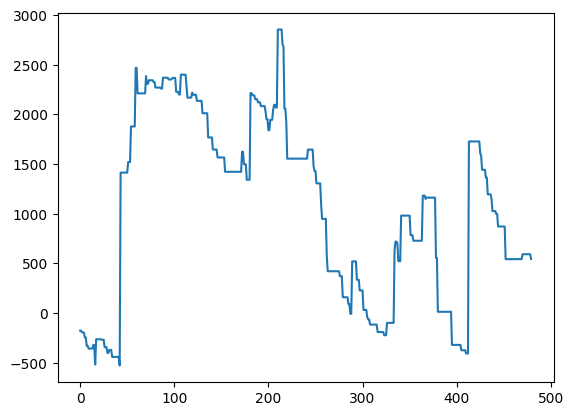

In [52]:
plt.plot(np.cumsum(totoal))

In [37]:
maxholding = 0
winrate = 0
total_trades = 0
for trade in trades:
    maxholding = max(maxholding,len(trade['Entry_Prices']))
    total_trades += len(trade['Entry_Prices'])
    if trade.get('PnL', 0) > 0:
        winrate += len(trade['Entry_Prices'])
winrate = winrate/total_trades
winrate

NameError: name 'trades' is not defined

In [195]:
result

,datetime,open,high,low,close,volume,ATR,Donchian_High,Donchian_Low,Signal,Position,Trade_Price,Cum_PnL
0,2023-03-02 09:29:00,6389.8,6389.8,6389.8,6389.8,127,NaN,NaN,NaN,0,0,NaN,0.0
1,2023-03-02 09:30:00,6385.2,6391.0,6383.6,6388.6,65462,NaN,NaN,NaN,0,0,NaN,0.0
2,2023-03-02 09:31:00,6388.8,6394.0,6388.0,6393.0,131105,6.700000,NaN,NaN,0,0,NaN,0.0
3,2023-03-02 09:32:00,6393.2,6395.0,6388.6,6392.6,213605,6.550000,NaN,NaN,0,0,NaN,0.0
4,2023-03-02 09:33:00,6392.6,6392.6,6386.2,6388.6,248803,6.475000,NaN,NaN,0,0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76266,2024-06-25 14:55:00,4915.2,4920.8,4915.2,4920.6,6174046,4.828639,4925.8,4901.0,0,0,NaN,-2137.6
76267,2024-06-25 14:56:00,4920.8,4921.0,4919.2,4920.2,6097425,3.314319,4925.8,4904.2,0,0,NaN,-2137.6
76268,2024-06-25 14:57:00,4919.8,4924.0,4919.8,4924.0,6184821,3.757160,4925.8,4904.2,0,0,NaN,-2137.6
76269,2024-06-25 14:58:00,4923.8,4925.4,4921.0,4922.8,6003023,4.078580,4925.8,4904.2,0,0,NaN,-2137.6


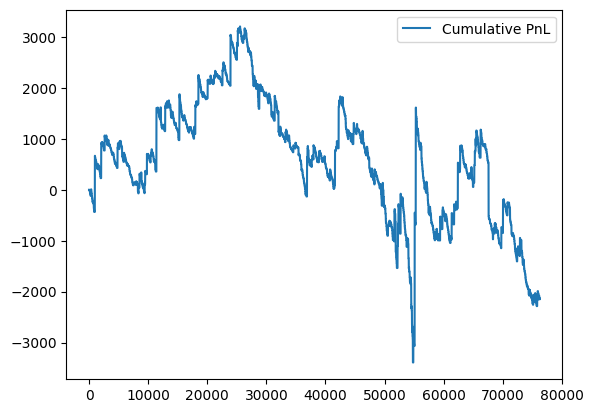

In [196]:
import matplotlib.pyplot as plt
# plt.plot(result['close'], label='Close Price')
# plt.plot(result['Donchian_High'], label='Donchian High')
# plt.plot(result['Donchian_Low'], label='Donchian Low')
plt.plot(result['Cum_PnL'], label='Cumulative PnL')
plt.legend()
plt.show()

In [177]:
dirpath = 'data/IM'
direc = os.listdir(dirpath)
ttpnl = []
wholef = pd.DataFrame()
for file_name in direc:

    df = pd.read_csv(os.path.join(dirpath,file_name), encoding='gbk')

    f = df[['LastPrice','Volume']].copy()
    f.columns = ['price','volume']
    f.loc[:,'time'] = pd.to_datetime(df['TradingDay'].astype(str) + ' ' + df['UpdateTime'])
    ff = tick_to_minute(f, freq="min").iloc[1:-4,:]

    result, trades = turtle_backtest(ff, channel_period=2, atr_period=2, add_threshold=0.1, stop_loss_mult=2.4)

    # 输出最后几行回测结果
    # print(result[['open', 'high', 'low', 'close', 'ATR', 'Donchian_High', 'Donchian_Low', 'Signal', 'Position', 'Cum_PnL']].tail())

    day_pnl = 0
    # 输出交易记录
    # print("交易记录：")
    for trade in trades:
        day_pnl += trade.get('PnL', 0)
    ttpnl.append(day_pnl)
    print(day_pnl,file_name)

-192.00000000000182 IM_20230302.csv
-274.99999999999727 IM_20230303.csv
-226.79999999999654 IM_20230306.csv
-238.40000000000236 IM_20230307.csv
-200.80000000000382 IM_20230308.csv
-348.3999999999969 IM_20230309.csv
-189.8000000000011 IM_20230310.csv
-488.199999999998 IM_20230313.csv
-365.99999999999454 IM_20230314.csv
-234.59999999999854 IM_20230315.csv
-257.99999999999363 IM_20230316.csv
-211.39999999999964 IM_20230317.csv
-173.19999999999254 IM_20230320.csv
-377.40000000000236 IM_20230321.csv
-217.20000000000346 IM_20230323.csv
-161.5999999999931 IM_20230324.csv
-172.59999999999945 IM_20230327.csv
-175.00000000000546 IM_20230328.csv
-111.20000000000528 IM_20230329.csv
-671.3999999999978 IM_20230330.csv
-258.0000000000009 IM_20230331.csv
-106.00000000000455 IM_20230403.csv
-177.800000000002 IM_20230404.csv
-147.59999999999854 IM_20230406.csv
-327.39999999999964 IM_20230407.csv
-196.60000000000218 IM_20230410.csv
-63.599999999999454 IM_20230411.csv
-124.79999999999836 IM_20230412.csv
-

In [166]:
local_path = 'E:/ryse/LocalDatabase'
code = 'IM'
# os.makedirs(f'data/{code}', exist_ok=True)
f = pd.read_csv(local_path + '/' + code + '.csv')

f = f[f['Date'] >= 20230302].reset_index(drop=True)

for dt in range(len(f['Date'])):
    date = f['Date'][dt]
    filename = f'{code}_{date}.csv'
    if not os.path.exists(f'data/{code}/{filename}'):
        print(f'Not Processed {filename}')
    if date == 20230829:
        continue

Not Processed IM_20230322.csv
Not Processed IM_20230428.csv
Not Processed IM_20230814.csv
Not Processed IM_20230829.csv
Not Processed IM_20250311.csv
Not Processed IM_20250312.csv
Not Processed IM_20250313.csv
Not Processed IM_20250314.csv
Not Processed IM_20250317.csv
